In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian, quantile_s2p
import time as time
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-06-02 01:11:54.693991: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Function Definitions

In [4]:
def find_coverage_calib(y, y_upper_all, y_lower_all, ci, flag=False):
    q_hats = []
    times = []
    E_is = []
    random_seed = 42
    np.random.seed(random_seed)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_upper_all[i]
            initial_lower = y_lower_all[i]
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            # E_i = E_i + np.random.normal(0, 10, len(E_i))

            E_is.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, E_is

In [5]:
def find_coverage_train_test(y, y_upper_all, y_lower_all, ci, q_hats, flag=False):
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_upper_all[i] + q_hats[i]
            lower = y_lower_all[i] - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

In [7]:
def get_trained_model(ci, x_train, y_train):
    alpha = 1 - ci
    lower_params_all = []
    upper_params_all = []
    lower_model_all = []
    upper_model_all = []
    for i in range(len(ci)):
        # define model
        lower_model = quantile_s2p.QuantileRegression(alpha=alpha[i]/2)
        upper_model = quantile_s2p.QuantileRegression(alpha=1 - alpha[i]/2)

        # initialize model and train
        lower_params = lower_model.init(jax.random.PRNGKey(0), x_train, True)
        lower_params, lower_losses = fit(lower_model, lower_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        upper_params = upper_model.init(jax.random.PRNGKey(0), x_train, True)
        upper_params, upper_losses = fit(upper_model, upper_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        lower_model_all.append(lower_model)
        upper_model_all.append(upper_model)
        lower_params_all.append(lower_params)
        upper_params_all.append(upper_params)
    return lower_params_all, upper_params_all, lower_model_all, upper_model_all

In [8]:
def get_all(ci, x, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler):
    lower_all = []
    upper_all = []
    for i in range(len(ci)):
        # get predictions x = {cal, test}
        y_hat_lower = lower_model_all[i].apply(lower_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        y_hat_upper = upper_model_all[i].apply(upper_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        mean_upper = scaler.inverse_transform(y_hat_upper)
        mean_lower = scaler.inverse_transform(y_hat_lower)
        lower_all.append(mean_lower)
        upper_all.append(mean_upper)
    return lower_all, upper_all

# Model Training

In [9]:
train = {
    2: {
        'start_time': "2013-07-01",
        'end_time': "2013-07-31"
    },
    5: {
        'start_time': "2014-07-01",
        'end_time': "2014-07-31"
    }
}
test = {
    1: {
        'start_time': "2014-07-01",
        'end_time': "2014-07-31"
    }
}
appliances = ["washingmachine"]

In [10]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [11]:
y_true_cal = scaler_y.inverse_transform(y_cal)
y_train_scaled = scaler_y.inverse_transform(y_train)

# Before Calibration

In [12]:
ci = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [13]:
lower_params_all, upper_params_all, lower_model_all, upper_model_all = get_trained_model(
    ci, x_train, y_train)

In [14]:
lower_train_all, upper_train_all = get_all(
    ci, x_train, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_test_all, upper_test_all = get_all(
    ci, x_test, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_cal_all, upper_cal_all = get_all(
    ci, x_cal, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)

In [15]:
initial_coverages_cal, _, _, _ = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci)
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, [])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, [])

In [16]:
initial_coverages_cal

array([0.        , 0.16618982, 0.24907741, 0.31367915, 0.42994568,
       0.44483145, 0.5180578 , 0.70240909, 0.79541402, 0.90504623,
       1.        ])

In [17]:
initial_coverages_test

array([0.        , 0.0172122 , 0.02583426, 0.03164618, 0.04049177,
       0.0349992 , 0.06083347, 0.09308638, 0.08184576, 0.13255627,
       1.        ])

In [18]:
initial_coverages_train

array([0.        , 0.1729209 , 0.26263631, 0.32744537, 0.44961369,
       0.46090586, 0.53815428, 0.71688021, 0.80850299, 0.91419607,
       1.        ])

# After Calibration

### Conformal Prediction

In [19]:
flag = True
final_coverages_cal, q_hats, times, Errors_all_cal = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci, flag=flag)
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, q_hats, flag=flag)
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, q_hats, flag=flag)

In [20]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.3080441182568313 and ece error is 0.02800401075062103
Final ace error is 0.0007256292241985957 and ece error is 6.596629310896325e-05


In [21]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.35313540932398996 and ece error is 0.03210321902945363
Final ace error is 0.11867838730632613 and ece error is 0.010788944300575103


In [22]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)
print('Test:')
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Test:
Initial ace error is 3.9814945049583907 and ece error is 0.3619540459053083
Final ace error is 3.9813667666167016 and ece error is 0.36194243332879106


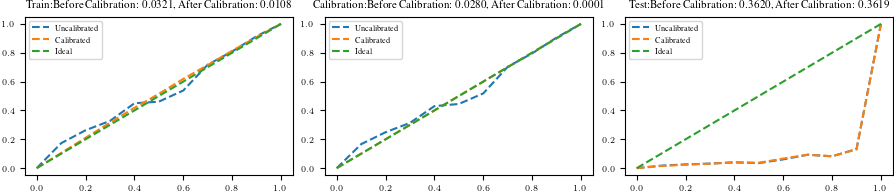

In [23]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')